## Markov chain

Классическая марковская цепь первого порядка. Строились цепи как отдельно для нот и длительностей, так и для конкатенации.

In [1]:
import sys
sys.path.append('src/')
import numpy as np
import matplotlib.pyplot as plt

from models.markov_chain import MarkovChain
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries
from save_midi import save_notes_and_durations

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [5]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [6]:
notes[:10]

['C#3.F#2.', 'F#2.', 'F#2.', '', 'F#2.', 'F#2.', 'F#2.', 'G2.', 'F#2.', '']

In [7]:
durations[:10]

[1.0, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]

### Separated

In [8]:
markov_notes = MarkovChain()
markov_notes.fit_partial(notes_to_int)

In [9]:
markov_durations = MarkovChain()
markov_durations.fit_partial(durations_to_int)

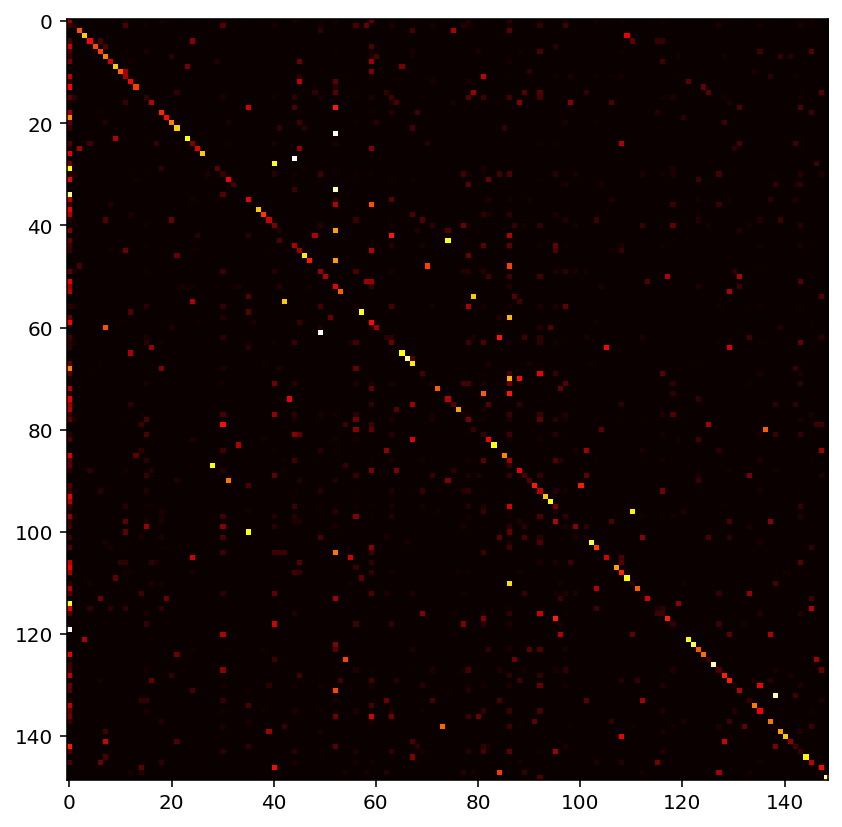

In [10]:
note_matrix = markov_notes.heatmap_of_transitions()

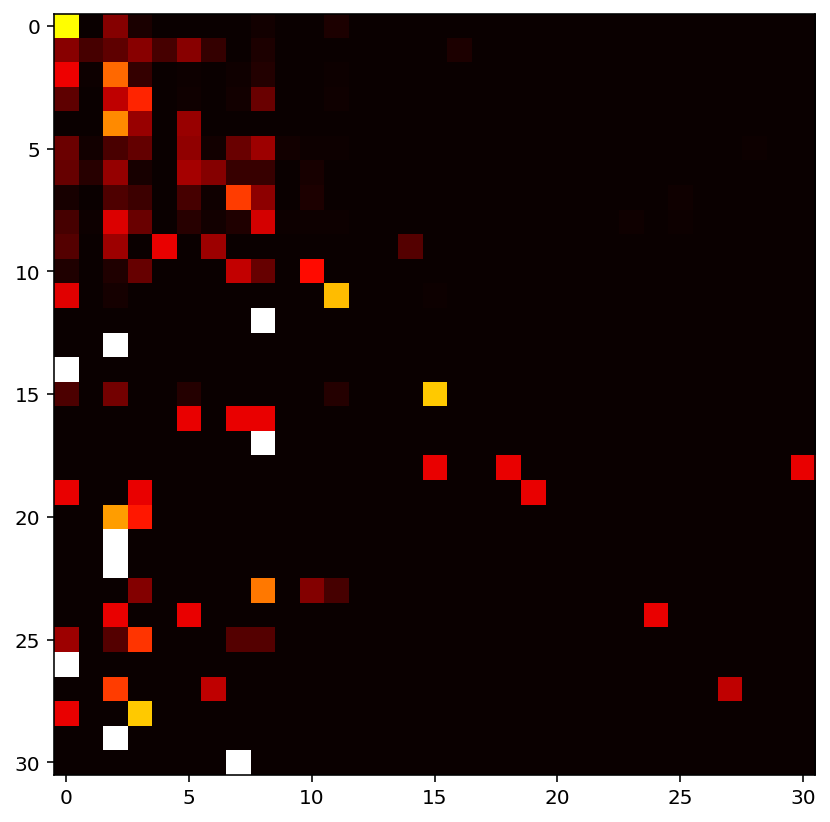

In [11]:
duration_matrix = markov_durations.heatmap_of_transitions()

In [12]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [13]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_notes = [note_dictionary['B2.']]
#     generated_notes = [note_dictionary['46.36.']]
    generated_durations = [duration_dictionary[1/16]]
    for i in range(100):
        probas = [markov_notes.predict_proba_state_transition(generated_notes[i], note_dictionary[x]) + 1e-6 for x in note_dictionary]
        generated_notes.append(sample(probas, temperature))

        probas = [markov_durations.predict_proba_state_transition(generated_durations[i], duration_dictionary[x]) + 1e-6 for x in duration_dictionary]
        generated_durations.append(sample(probas, temperature))
    
    generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]
    save_notes_and_durations(generated, f'output/markov/markov_output_{temperature}')

### Concatenated

In [17]:
combined = []
for note, duration in zip(notes, durations):
    combined.append(str(note) + '|' + str(duration))

In [19]:
len(set(combined))

657

In [21]:
combined_dict = {element: i for i, element in enumerate(set(combined))}
inv_combined_dict = {k: v for v, k in combined_dict.items()}
combined_to_int = [combined_dict[element] for element in combined]

In [22]:
markov_combined = MarkovChain()
markov_combined.fit_partial(combined_to_int)

In [35]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_combined = [combined_dict['B1.|0.1875']]
    for i in range(100):
        probas = [markov_combined.predict_proba_state_transition(generated_combined[i], combined_dict[x]) + 1e-6 for x in combined_dict]
        generated_combined.append(sample(probas, temperature))
    
    generated_notes, generated_durations = [], []
    for element in generated_combined:
        element = inv_combined_dict[element]
        note, duration = element.split('|')
        generated_notes.append(note)
        generated_durations.append(float(duration))
        
    generated = [generated_notes, generated_durations]
    save_notes_and_durations(generated, f'output/markov/markov_combined_{temperature}')